# Figure 2

- Notebook to make data for figure 2 (likely a map)
- by Cascade Tuholske on 2020.10.01

#### Depdencies

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import seaborn as sns
import glob
from matplotlib.colorbar import Colorbar

#### Functions

In [2]:
def pop_stat(df, geog, stats):
    
    """Finds linear coef for increase in stat by a given geography from 1983 - 2016, as well
    as the pct change in population of the cities within the given geography"""

    # Get results
    labels = []
    delt_list = []
    r2_list = []
    coef_list = []
    p_list = []
    df_out = pd.DataFrame()

    for label, df_geog in df.groupby(geog):

        # Get Data
        X_year = np.array(df_geog.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
        Y_stats = np.array(df_geog.groupby('year')[stats].sum()).reshape((-1, 1))

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit() 
        
        # Get slope
        # first param in intercept coef, second is slope of line but if slope = 0, then intecept
        if len(model.params) == 2:
            coef = model.params[1]
            
        else:
            coef = model.params[0]
        
        # R2 and P
        r2 = model.rsquared_adj
        p = model.pvalues[0]

        # Pop change
        delt = df_geog.drop_duplicates('ID_HDC_G0').copy()
        delt['delt_pop'] = delt['P2016'] - delt['P1983']
        delt = delt['delt_pop'].sum()


        # Make lists
        labels.append(label)
        r2_list.append(r2)
        coef_list.append(coef)
        p_list.append(p)
        delt_list.append(delt)

    # Make data frame
    df_out[geog] = labels
    df_out['p_delt'] = delt_list
    df_out['r2'] = r2_list
    df_out['coef'] = coef_list
    df_out['p_value'] = [round(elem, 4) for elem in p_list]

    return df_out

#### Load and Make Data

In [3]:
# file path
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
FN_raw = 'processed/All_data_Raw406_es_final_pdayadd.csv'
raw_stats = pd.read_csv(DATA_IN+FN_raw)

# Sub-Region Tmax Days increase scatter with color as total people days regression line

Here we want find the regions with the greatest increase in the total numbers of exposure days in a given year and then make graphs at the country level with a sig. trend line

In [12]:
# Find Regions where the trend in people days due to heat is sig at 0.05
heat_stat = 'total_days'
pdays_stat = 'people_days'
geog = 'sub-region'
df_region = pop_stat(raw_stats, geog, heat_stat)
df_region = df_region[df_region['p_value'] < 0.05]
sig_regions = list(df_region[geog])
len(sig_regions)

8

#### Single Col

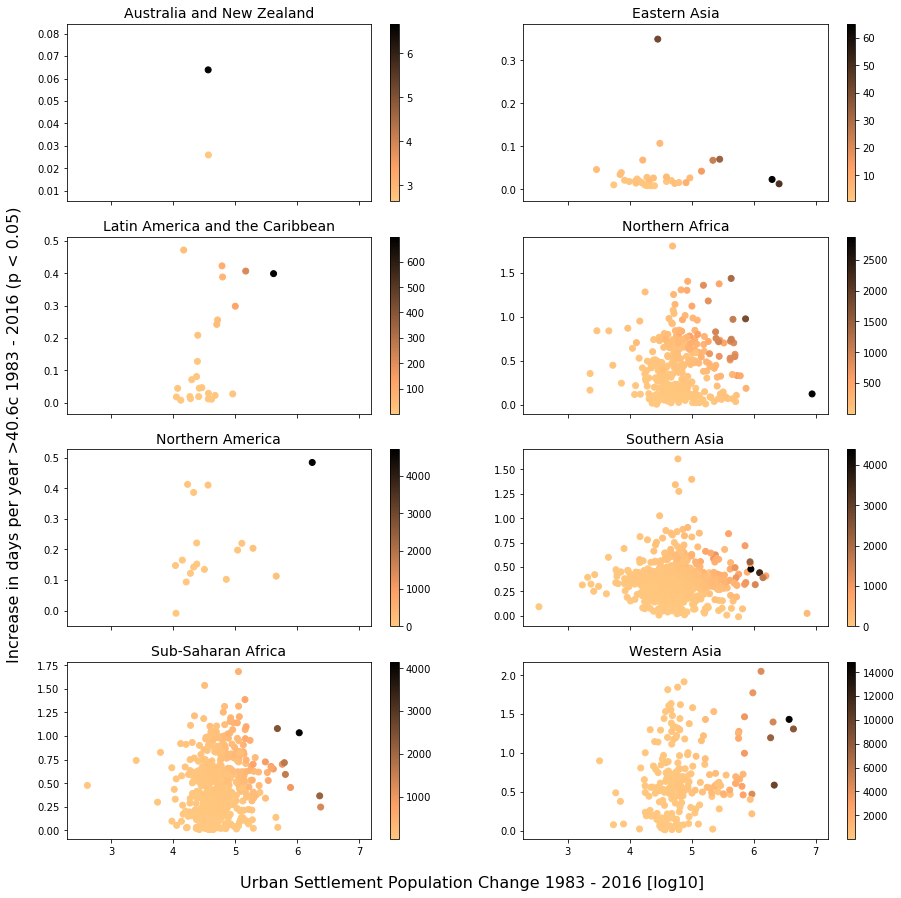

In [28]:
fig, axs = plt.subplots(4, 2, figsize = (15, 15), sharex=True)
axs = axs.ravel()
counter = 0

for i, region in enumerate(sig_regions):
    
    df_region = raw_stats[raw_stats[geog] == region] # select region
    
    # Get people days dues to heat coef
    heat = pop_stat(df_region, 'ID_HDC_G0', heat_stat) # get stats 
    heat = heat[heat['p_value'] < 0.05] # subset by p value
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    
    # Get people days total
    pdays_all = pop_stat(df_region, 'ID_HDC_G0', 'people_days') # get stats
    pdays_all.rename(columns={"coef": "coef_pday"}, inplace = True)
    
    # try to merge them
    heat = heat.merge(pdays_all[['ID_HDC_G0', 'coef_pday']], on = 'ID_HDC_G0', how = 'left')
    
    # plots
    a = i + counter
    im  = axs[a].scatter(np.log10(heat['p_delt']), heat['coef_heat'], alpha = 0.99, 
                  c = heat['coef_pday']*10**6, cmap = 'copper_r')
    axs[a].set_title(region, fontsize = 14)
    
    fig.colorbar(ax = axs[a], mappable = im)

fig.text(0.5, 0.08, 'Urban Settlement Population Change 1983 - 2016 [log10]', ha='center', size = 16)
fig.text(0.07, 0.5, 'Increase in days per year >40.6c 1983 - 2016 (p < 0.05)', va='center', rotation='vertical',
        size = 16)
plt.savefig(FIG_OUT+'FIG2.png') 

#### Double Col

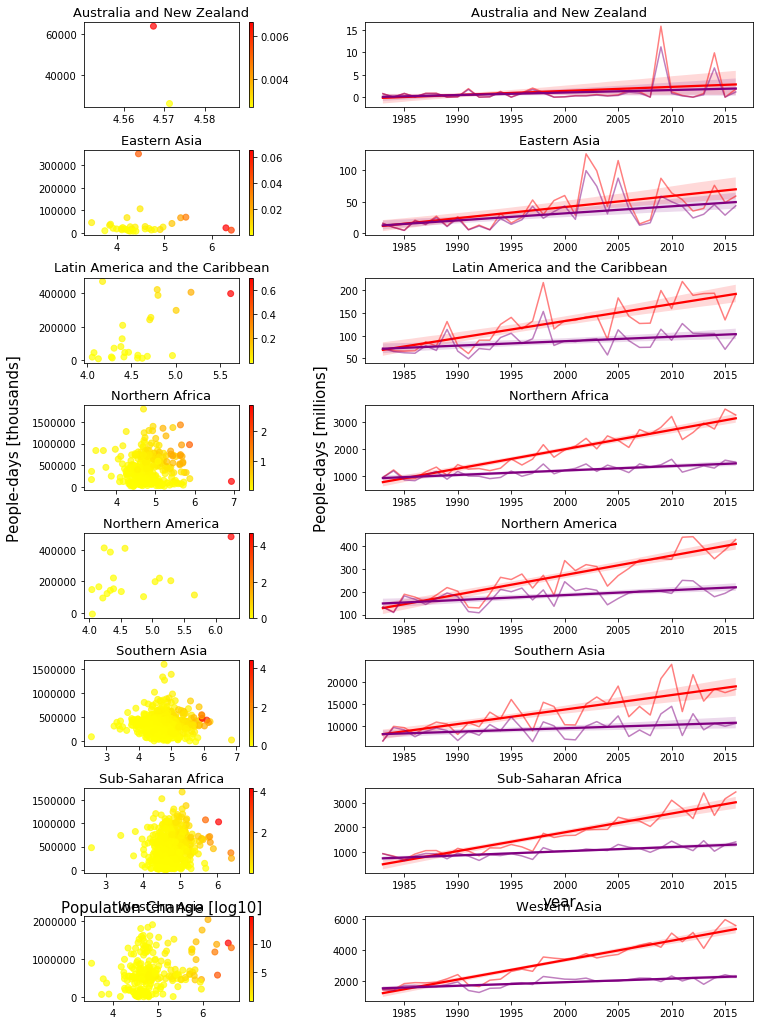

In [18]:
from matplotlib import gridspec

fig = plt.figure(figsize = (12, 18))
gs = gridspec.GridSpec(ncols = 2, nrows= 8, width_ratios=[1, 2], hspace = .5, wspace = .3)

a = 0
b = 0
j = 0

for i, region in enumerate(sig_regions):
    
    df_region = raw_stats[raw_stats[geog] == region] # select region
    
    # Plot % change pop vs. slope of people days
    axs[j] = plt.subplot(gs[i,0])

    # Get people days dues to heat coef
    heat = pop_stat(df_region, 'ID_HDC_G0', heat_stat) # get stats 
    heat = heat[heat['p_value'] < 0.05] # subset by p value
    heat.rename(columns={"coef": "coef_heat"}, inplace = True)
    
    # Get people days total
    pdays_all = pop_stat(df_region, 'ID_HDC_G0', 'people_days') # get stats
    pdays_all.rename(columns={"coef": "coef_pday"}, inplace = True)
    
    # try to merge them
    heat = heat.merge(pdays_all[['ID_HDC_G0', 'coef_pday']], on = 'ID_HDC_G0', how = 'left')

    # plot it --->>>> 10**6 slopes are in thousands of peopl days
    im = axs[j].scatter(np.log10(heat['p_delt']), heat['coef_heat']*10**6, alpha = 0.7, 
                  c = heat['coef_pday']*10**3, cmap = 'autumn_r') #color = 'darkmagenta') 
    
    fig.colorbar(ax = axs[j], mappable = im)
    
    # Plot attributes
    #ax1.set_xlim([0, 5])
    axs[j].set_title(region, fontsize = 13)
    
    b = a + 1
    
    # Left Axis labels 
    if b == 7:
        axs[j].set_ylabel('People-days [thousands]', fontsize = 15, labelpad = 10)
    if b == 13:
        axs[j].set_xlabel('Population Change [log10]', fontsize = 15, labelpad = 10)
    
    # Plot time series
    axs[j] = plt.subplot(gs[i, 1])
    data = raw_stats[raw_stats[geog] == region].groupby('year')['people_days'].sum() *10**3
    years = list(data.index)
    axs[j].plot(data, color = 'red', linestyle = '-', alpha = 0.5)
    #axs[i].fill_between(years, data, color = 'red', alpha = 0.05, label='_nolegend_')
    sns.regplot(years, data, color = 'red', ax = axs[j], scatter = False, truncate = True)
    
    # people days 83 plot
    data = raw_stats[raw_stats[geog] == region].groupby('year')['people_days_heat'].sum() *10**3
    years = list(data.index)
    axs[j].plot(data, color = 'purple', linestyle = '-', alpha = 0.5)
    #axs[i].fill_between(years, data, color = 'purple', alpha = 0.1, label='_nolegend_')
    sns.regplot(years, data, color = 'purple', ax = axs[j], scatter = False, truncate = True)
    axs[j].set_ylabel('')
    axs[j].set_title(region, fontsize = 13)

    if b == 7:
        axs[j].set_ylabel('People-days [millions]', fontsize = 15)
    
    if b == 13:
        axs[j].set_xlabel('year', fontsize = 15)
    
    a = b + 1
#plt.savefig(FIG_OUT+'FIG2.png')  